In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [3]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [4]:
from model_PyG import *
from utils import *

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [6]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [7]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [8]:
dataset = "ACM_DBLP" # "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		"Orange_1", "Orange_2",
		"Red_1", "Red_2",
		"Yellow_1", "Yellow_2",
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100
elif (dataset == "vanessa_05"):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		"FrescoCusco_1", "FrescoCusco_2",
		"FrescoSanMartin_1", "FrescoSanMartin_2",
		"SecoAmazonas_1", "SecoAmazonas_2",
		"SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 150

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [9]:
transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

In [ ]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["vanessa_05", "mentos_05"]: # Change
	for ts in train_set:
		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values, dtype=torch.long)
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float)

		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, intensity_mean, intensity_cv
		x = torch.tensor(df_nodes.iloc[:, 2:-1].values, dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)
		data = transform(data)
		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 9872
Num. edges:	 88994
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9869, 9870, 9871],
        [   1,    2,    3,  ..., 9869, 9870, 9871]], device='cuda:1')
tensor([[61., 42., 16.,  ..., 14.,  1., 22.],
        [54., 18., 12.,  ..., 11.,  0., 16.],
        [54., 61.,  9.,  ..., 10.,  0., 39.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.]], device='cuda:1')
None
Validate:	 True
Num. nodes:	 9916
Num. edges:	 99532
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9913, 9914, 9915],
        [ 450, 4031, 4447,  ..., 9913, 9914, 9915]], device='cuda:1')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0

In [11]:
train_loader

{'ACM': Data(x=[9872, 17], edge_index=[2, 88994]),
 'DBLP': Data(x=[9916, 17], edge_index=[2, 99532])}

### Train

In [12]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [13]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-2 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]
			x = data.x
			edge_index = data.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			z = model(data.x, data.edge_index).detach()
			dict_node_embeddings[ts] = z.cpu().numpy()

	torch.cuda.empty_cache()

	return dict_node_embeddings, list_loss

In [14]:
train_set

['ACM', 'DBLP']

In [15]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
ACM_DBLP 0.0001 100 17 128 2


Epoch: 45:  44%|████▍     | 44/100 [00:39<00:50,  1.10it/s, Loss: 0.4350]


Stopping early as no improvement has been observed.
Early stopping at epoch 45


### Get embeddings

In [16]:
dict_node_embeddings

{'ACM': array([[-1.2219660e+00, -2.5449312e+00, -6.8822837e-01, ...,
          1.8446883e+00, -7.4213691e-02,  5.2722651e-01],
        [-1.5148637e+00, -1.7706401e+00, -4.1950044e-01, ...,
          6.1305928e-01, -8.7368762e-01,  2.7735105e-01],
        [-1.1555467e+00, -3.9803071e+00, -7.4388844e-01, ...,
          1.9549694e+00,  1.4070737e+00,  7.6636739e-02],
        ...,
        [-5.7874687e-02, -1.8560399e-01,  1.3974681e-01, ...,
          2.3692819e-01,  2.0652076e-02,  6.6564471e-02],
        [ 2.0581650e-02,  1.3247724e-01, -4.9862012e-02, ...,
         -2.2264393e-01, -2.1180326e-02, -1.2865114e-01],
        [-3.3678249e-03,  1.5178636e-01,  9.7355373e-02, ...,
          2.7440656e-02,  2.6179102e-01, -9.8861031e-02]], dtype=float32),
 'DBLP': array([[-0.09329086,  0.16837369, -0.22950597, ...,  0.02556834,
         -0.00692487, -0.13111578],
        [-0.05457378,  0.03401925,  0.00392915, ..., -0.19017035,
         -0.28925836, -0.05903675],
        [-0.11536483, -0.087820

### Plot

In [17]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(19788, 128)


array([[-1.221966  , -2.5449312 , -0.68822837, ...,  1.8446883 ,
        -0.07421369,  0.5272265 ],
       [-1.5148637 , -1.7706401 , -0.41950044, ...,  0.6130593 ,
        -0.8736876 ,  0.27735105],
       [-1.1555467 , -3.980307  , -0.74388844, ...,  1.9549694 ,
         1.4070737 ,  0.07663674],
       ...,
       [ 0.11945838,  0.139126  , -0.2622198 , ..., -0.16075146,
        -0.19486384, -0.2627535 ],
       [ 0.25191104,  0.01315835,  0.1252852 , ..., -0.02858754,
         0.02651543, -0.20196491],
       [ 0.16529521,  0.09095693, -0.12850682, ..., -0.18856052,
         0.11039335,  0.14539483]], dtype=float32)

In [18]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
    labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

19788
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
list_loss

[0.8241277933120728,
 9.895291328430176,
 0.8953299522399902,
 1.2152174711227417,
 1.2938467264175415,
 0.6772735714912415,
 0.5697156190872192,
 0.6572996377944946,
 0.6814241409301758,
 0.5790905952453613,
 0.5243113040924072,
 0.528938889503479,
 0.5531802177429199,
 0.5532865524291992,
 0.5182490944862366,
 0.49247926473617554,
 0.48857182264328003,
 0.49693727493286133,
 0.5029294490814209,
 0.49209439754486084,
 0.4797096848487854,
 0.4700284004211426,
 0.466224730014801,
 0.4699304699897766,
 0.47184139490127563,
 0.4688325822353363,
 0.46299469470977783,
 0.4542558789253235,
 0.4526127576828003,
 0.4515630602836609,
 0.4535127878189087,
 0.4512706696987152,
 0.4493997097015381,
 0.44514766335487366,
 0.4433576464653015,
 0.44207999110221863,
 0.443329393863678,
 0.44069477915763855,
 0.44005584716796875,
 0.4387527108192444,
 0.4354071021080017,
 0.435298353433609,
 0.43454357981681824,
 0.4352790415287018,
 0.43502277135849]

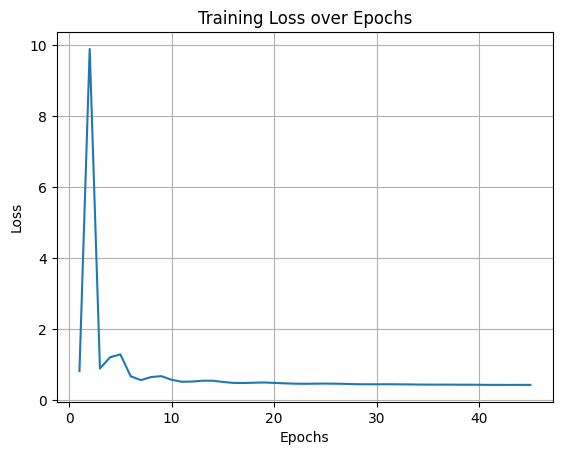

In [20]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

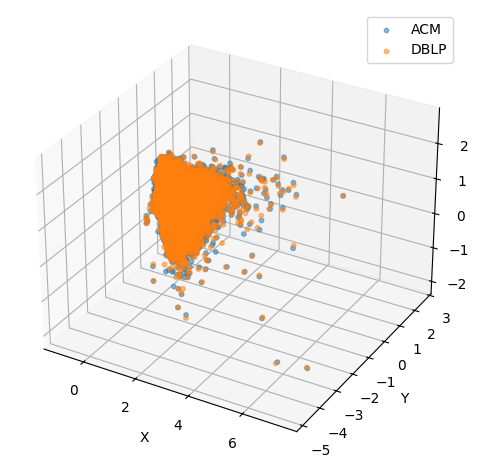

In [21]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

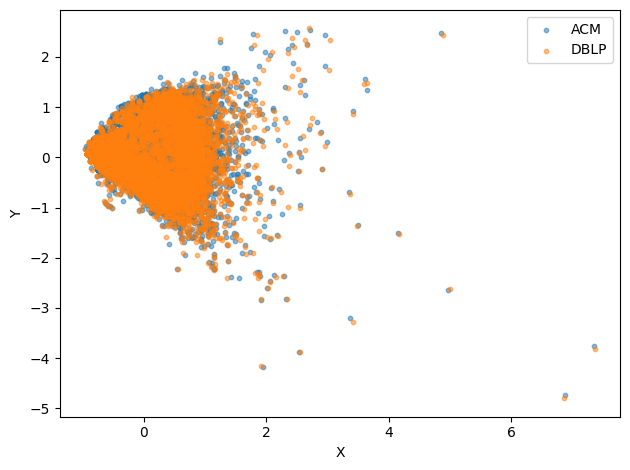

In [22]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [23]:
train_set

['ACM', 'DBLP']

In [24]:
# Get node ids

dict_node_id = {}

if dataset in ["vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
    for ts in train_set:
        dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'ACM': array([   0,    1,    2, ..., 9869, 9870, 9871]),
 'DBLP': array([   0,    1,    2, ..., 9913, 9914, 9915])}

In [25]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,ACM,DBLP
0,0,6829
1,1,601
2,2,3102
3,3,3584
4,4,3744
...,...,...
9867,9867,3057
9868,9868,9011
9869,9869,4378
9870,9870,5284


In [26]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

ACM DBLP


,ACM,DBLP


In [27]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

0


,ACM,DBLP


In [28]:
# Comparison (with test_pairs)

if dataset not in ["vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

5060
       ACM  DBLP  mask
0        0  6829  True
2        2  3102  True
3        3  3584  True
4        4  3744  True
5        5   685  True
...    ...   ...   ...
9807  9807   152  True
9810  9810  5387  True
9820  9820  8501  True
9850  9850   306  True
9868  9868  9011  True

[3303 rows x 3 columns]


### Filter MS data

In [29]:
common_node_id = df_node_alignment_filter.iloc[:, 1].values
common_node_id

array([], dtype=int64)

In [30]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

FileNotFoundError: [Errno 2] No such file or directory: 'data/ACM_DBLP/raw.csv'

In [ ]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

In [ ]:
# Comparison (sta)
list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)